In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import GridSearchCV

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")


In [2]:
fraud_transactions = pd.read_csv('./datasets/creditcard-modified.csv',index_col=0)
fraud_transactions.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
91771,63621.0,-0.960137,1.206609,2.026405,-0.628816,0.201602,-0.898113,1.100185,-0.354583,-0.225842,...,-0.271188,-0.705533,-0.212958,0.364038,0.234168,-0.027049,-0.208287,-0.102126,2.69,0
205605,135832.0,2.031877,-0.097557,-1.209013,0.435114,-0.009684,-1.092250,0.281522,-0.371851,0.504616,...,-0.239962,-0.534819,0.240245,-0.078971,-0.162834,0.279192,-0.073682,-0.059863,24.01,0
246685,153282.0,2.051962,0.628752,-2.342524,1.437871,1.164495,-0.873292,0.734087,-0.386544,-0.031124,...,-0.038181,0.167084,-0.012515,0.508870,0.535805,-0.517944,0.007064,-0.022177,1.00,0
212610,138926.0,0.089688,0.264593,-0.328242,-2.416836,0.537514,-0.950072,0.676234,-0.272587,-1.151421,...,0.544267,1.640856,-0.123822,0.646009,-0.629648,-0.234901,0.455501,0.311445,15.00,0
82999,59646.0,1.274163,0.414063,-0.033853,0.920460,0.266021,-0.450671,0.335275,-0.280055,-0.213540,...,0.001111,0.101484,-0.236981,-0.409455,0.849685,-0.283042,0.020660,0.018032,20.00,0
27890,34754.0,1.391007,-1.469809,1.168768,-1.134833,-2.088535,0.077296,-1.733541,0.245543,-0.810584,...,-0.226671,-0.138953,0.106559,0.034314,0.121243,-0.161810,0.084089,0.027576,22.00,0
209075,137403.0,2.151015,-0.070477,-2.571981,-0.338708,1.002019,-0.596894,0.500956,-0.201453,0.256297,...,0.125406,0.366472,-0.085471,-0.105760,0.458337,0.247256,-0.103831,-0.094871,0.75,0
150566,93675.0,-1.087730,1.549232,0.165606,-0.979235,1.204379,0.902956,-0.467572,-2.592983,0.683055,...,-1.513069,-0.040886,-0.240288,-0.343415,0.806495,0.019315,-0.250360,-0.019673,13.00,0
246383,153152.0,1.841520,-0.753772,0.040719,0.995352,-1.228052,0.053056,-1.177330,0.253539,2.366046,...,-0.187204,-0.077837,0.207633,-0.070350,-0.440856,0.571945,0.030094,-0.008738,41.87,0
140447,83729.0,-0.126631,-0.183058,-2.490716,-2.302333,0.197675,3.040177,-2.378229,1.996806,-2.384884,...,-0.011055,-0.188586,0.489661,0.966362,-0.770721,-0.331808,-0.596116,-0.390682,10.00,0


In [3]:
fraud_transactions.shape

(60000, 31)

Time variable
213474    38.686111
49951     12.299444
167663    33.007222
51076     12.439167
133482    22.335278
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

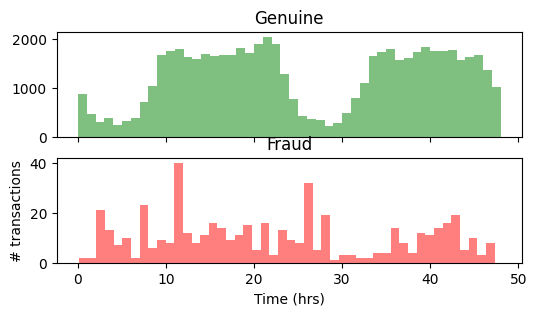

In [4]:
#plot Time to see if there is any trend
print("Time variable")
fraud_transactions["Time_Hr"] = fraud_transactions["Time"]/3600 # convert to hours
print(fraud_transactions["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(fraud_transactions.Time_Hr[fraud_transactions.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(fraud_transactions.Time_Hr[fraud_transactions.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

In [5]:
from sklearn.preprocessing import StandardScaler
fraud_transactions = fraud_transactions.drop(['Time'],axis=1)
fraud_transactions['Amount_Scaled'] = StandardScaler().fit_transform(fraud_transactions['Amount'].values.reshape(-1,1))
fraud_transactions = fraud_transactions.drop(['Amount'],axis=1)
fraud_transactions.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_Hr,Amount_Scaled
91771,-0.960137,1.206609,2.026405,-0.628816,0.201602,-0.898113,1.100185,-0.354583,-0.225842,-0.222244,...,-0.705533,-0.212958,0.364038,0.234168,-0.027049,-0.208287,-0.102126,0,17.672500,-0.348905
205605,2.031877,-0.097557,-1.209013,0.435114,-0.009684,-1.092250,0.281522,-0.371851,0.504616,0.031857,...,-0.534819,0.240245,-0.078971,-0.162834,0.279192,-0.073682,-0.059863,0,37.731111,-0.262528
246685,2.051962,0.628752,-2.342524,1.437871,1.164495,-0.873292,0.734087,-0.386544,-0.031124,-0.390117,...,0.167084,-0.012515,0.508870,0.535805,-0.517944,0.007064,-0.022177,0,42.578333,-0.355752
212610,0.089688,0.264593,-0.328242,-2.416836,0.537514,-0.950072,0.676234,-0.272587,-1.151421,0.243279,...,1.640856,-0.123822,0.646009,-0.629648,-0.234901,0.455501,0.311445,0,38.590556,-0.299032
82999,1.274163,0.414063,-0.033853,0.920460,0.266021,-0.450671,0.335275,-0.280055,-0.213540,-0.039789,...,0.101484,-0.236981,-0.409455,0.849685,-0.283042,0.020660,0.018032,0,16.568333,-0.278774


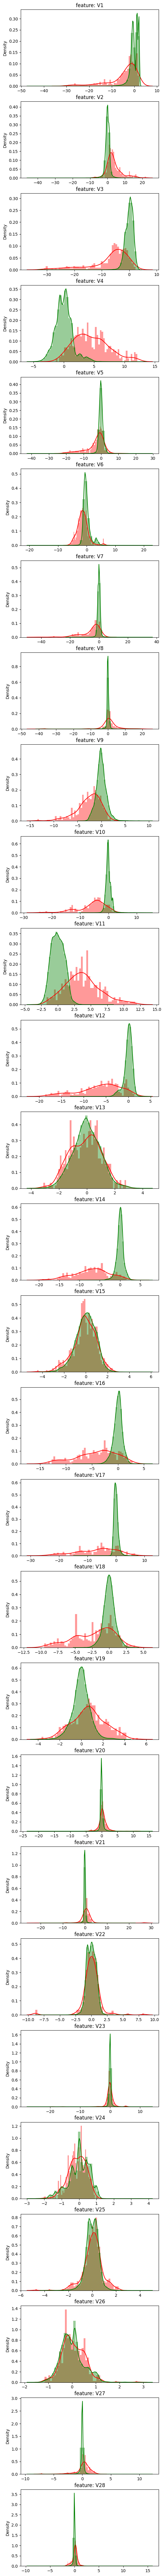

In [7]:
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(fraud_transactions[fraud_transactions.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(fraud_transactions[col][fraud_transactions.Class == 1], bins=50, color='r')
    sns.distplot(fraud_transactions[col][fraud_transactions.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

In [8]:
import plotly.express as px
labels=["Genuine","Fraud"]

fraud_or_not = fraud_transactions["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=fraud_transactions['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

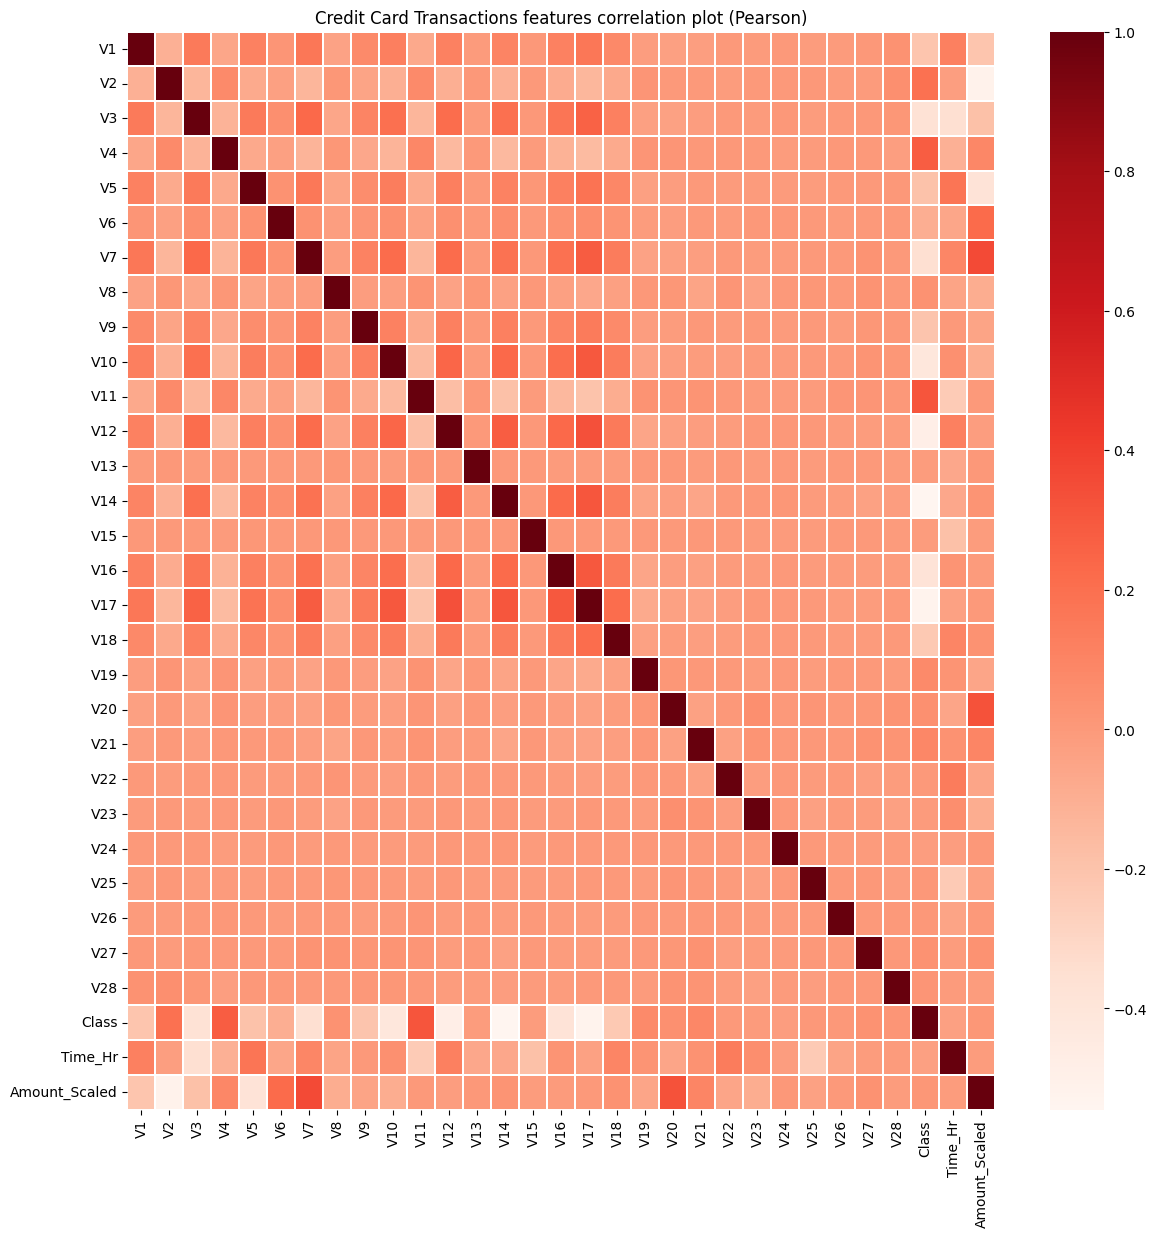

In [9]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = fraud_transactions.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [30]:
X = fraud_transactions.drop('Class', axis=1)
y = fraud_transactions['Class']

In [31]:
from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [32]:
y_train_all.value_counts()

0    41656
1      344
Name: Class, dtype: int64

In [33]:
y_test_all.value_counts()

0    17852
1      148
Name: Class, dtype: int64

In [34]:
X_test_all.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
104772,-1.205869,0.358476,0.941843,-1.283479,-0.691672,-1.064738,0.433261,-0.464115,-0.884868,0.997131,...,-0.204913,-0.867589,0.322618,0.314084,-0.274638,-0.754106,-0.934648,0.188482,19.228611,-0.193693
206818,1.794759,-0.165381,-1.714265,0.584960,0.036922,-1.271314,0.385374,-0.402575,0.793853,-0.990136,...,-0.166805,-0.407017,0.065720,-0.036951,-0.060594,-0.108318,-0.017697,0.005410,37.885278,0.152466
272985,2.070787,-0.226940,-1.528827,0.052052,0.392247,-0.198030,-0.003233,-0.045828,0.483416,0.256544,...,-0.308175,-0.837945,0.202859,-1.180607,-0.230090,0.253149,-0.079941,-0.082131,45.933056,-0.319330
193621,-2.588604,-0.326426,1.068028,3.657966,2.557784,0.614117,0.495115,-0.038830,-1.521187,1.186671,...,-0.265302,0.374919,0.518917,-0.040110,1.222879,0.465642,0.039979,-0.021340,36.170833,-0.316899
48559,0.398713,1.724824,-3.794925,0.528056,3.163993,2.335216,0.005451,1.110668,-0.572590,-1.240971,...,-0.141771,-0.485937,0.123842,0.653565,-0.286417,-0.395778,-0.001024,-0.058018,12.137222,-0.352552


In [35]:
X_train_all.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
53545,-0.093815,-0.054224,1.200260,-1.435211,-0.549693,-0.244441,0.044555,0.023849,-1.010845,0.180438,...,0.128804,0.110763,-0.104478,-0.613307,0.038312,-0.260330,0.015100,0.017628,12.786944,-0.126843
134602,0.747826,-0.997434,1.005095,0.222394,-0.711655,1.494682,-0.829095,0.616102,1.201171,-0.694889,...,-0.017038,0.047652,0.136171,-0.564585,-0.281898,1.038232,0.011225,0.024971,22.466667,0.206270
156162,2.055459,-0.091205,-0.560433,0.284060,0.021659,-0.077111,-0.468988,-0.173858,2.468768,-0.646549,...,-0.312378,-0.445311,0.220417,-1.145085,-0.220619,-0.899911,0.042414,-0.040433,29.847500,-0.330228
128688,1.061468,-0.485974,1.328993,0.334514,-1.515118,-0.736448,-0.574037,-0.027390,0.993413,-0.428699,...,-0.041914,-0.051695,0.068151,1.019617,0.031018,0.949131,-0.042637,0.033304,21.889444,-0.076402
199268,2.062067,0.022795,-1.040070,0.408877,-0.058218,-1.194963,0.253771,-0.393106,0.387746,0.043493,...,-0.276940,-0.614708,0.329014,0.074013,-0.265417,0.191973,-0.064144,-0.057642,36.910833,-0.351782


In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time. 

kf = StratifiedKFold(n_splits=5, shuffle=False)
rf = RandomForestClassifier(n_estimators=100, random_state=13)
nb=GaussianNB()
#cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

In [37]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(rf, X_train_all, y_train_all, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


Cross Validation Recall scores are: [0.88235294 0.79710145 0.85507246 0.7826087  0.82608696]
Average Cross Validation Recall score: 0.8286445012787723


In [38]:
score = cross_val_score(nb, X_train_all, y_train_all, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.88235294 0.8115942  0.84057971 0.8115942  0.84057971]
Average Cross Validation Recall score: 0.8373401534526854


In [39]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train_all, y_train_all)

In [40]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 200, 'random_state': 13}
Best score: 0.8344842284739983


In [42]:
y_pred = grid_rf.predict(X_test_all)

In [43]:
nb.fit(X_train_all, y_train_all)

GaussianNB()

In [45]:
y_pred_nb = nb.predict(X_test_all)

In [46]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test_all, y_pred_nb)

nb_Recall = recall_score(y_test_all, y_pred_nb)
nb_Precision = precision_score(y_test_all, y_pred_nb)
nb_f1 = f1_score(y_test_all, y_pred_nb)
nb_accuracy = accuracy_score(y_test_all, y_pred_nb)

print(cm)

[[17434   418]
 [   26   122]]


In [47]:
nbcf = [(nb_Recall, nb_Precision, nb_f1, nb_accuracy)]

rf_score = pd.DataFrame(data = nbcf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Naive Bayes with', 'No Under/Oversampling')
rf_score

,Naive Bayes with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.824324,0.225926,0.354651,0.975333


In [48]:

cm = confusion_matrix(y_test_all, y_pred)

rf_Recall = recall_score(y_test_all, y_pred)
rf_Precision = precision_score(y_test_all, y_pred)
rf_f1 = f1_score(y_test_all, y_pred)
rf_accuracy = accuracy_score(y_test_all, y_pred)

print(cm)

[[17850     2]
 [   29   119]]


In [49]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.804054,0.983471,0.884758,0.998278


In [50]:
fraud_transactions['Class'].value_counts()

0    59508
1      492
Name: Class, dtype: int64

In [51]:
df = fraud_transactions.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_Hr,Amount_Scaled
13950,-0.346979,-2.103284,-0.685061,1.961605,-0.401125,0.473632,1.133816,-0.256528,0.893409,-0.639733,...,-0.316275,-0.864259,-0.279881,0.491802,-0.353996,-0.149931,0.129795,0,6.876667,2.857886
46998,-1.109646,0.811069,-1.138135,0.935265,-2.330248,-0.116106,-1.621986,0.458028,-0.912189,-2.961996,...,0.841755,0.176728,0.081004,-0.258899,0.707654,0.418649,0.080756,1,11.952222,0.467793
190650,-2.033130,-0.030413,-0.711683,-1.176644,2.007220,-1.480176,1.477827,0.066682,-1.533911,-1.280738,...,0.873403,-0.567934,0.884931,1.694232,0.426568,-0.234809,-0.240011,0,35.812222,0.077757
215132,-2.921944,-0.228062,-5.877289,2.201884,-1.935440,0.631141,-1.245106,1.511348,-1.899987,-6.428231,...,0.895528,1.385511,-2.028024,0.509131,0.172643,0.726781,0.234514,1,38.875278,2.570271
192382,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,-3.224559,...,0.033958,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,1,36.018889,-0.351701


In [19]:
new_df.shape

(984, 31)

In [52]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 4.2 s
PCA took 0.2 s
Truncated SVD took 0.0046 s


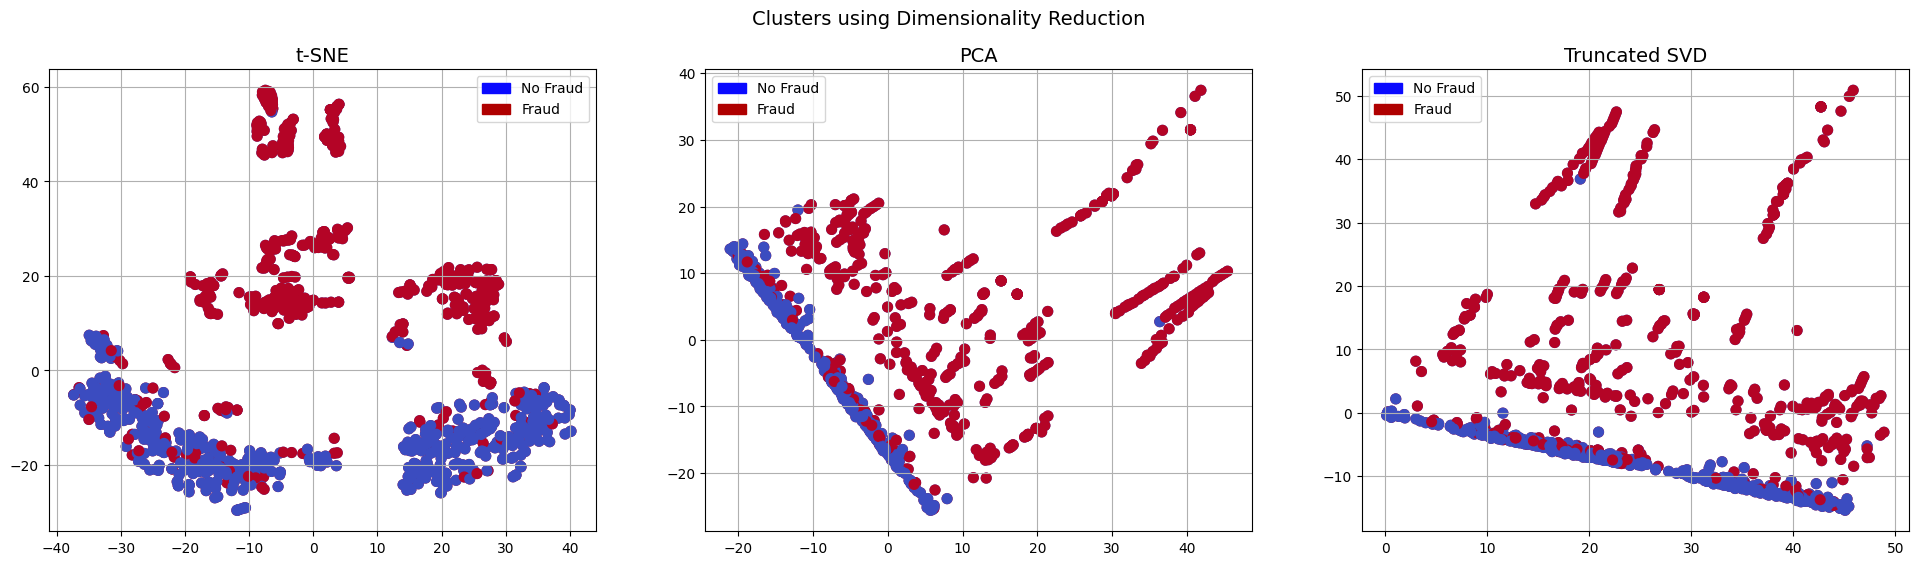

In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [53]:
# Undersampling before cross validating (prone to overfit)
X_under = new_df.drop('Class', axis=1)
y_under = new_df['Class']

In [54]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [75]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
count,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,...,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000
mean,-2.293928,1.691881,-3.348689,2.226133,-1.482693,-0.696814,-2.732870,0.342355,-1.253221,-2.730168,...,0.310880,-0.010629,-0.013281,-0.040343,0.022094,0.034542,0.108626,0.004846,24.742937,0.028921
std,5.480135,3.694812,6.160484,3.234660,4.201441,1.748817,5.808856,4.802977,2.307595,4.483748,...,2.694793,1.156288,1.267982,0.574178,0.666116,0.495549,0.931885,0.438348,13.101484,0.768139
min,-30.552380,-14.440363,-31.103685,-4.005898,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.174059,-5.682338,-2.404684,0.112778,-0.359804
25%,-2.765686,-0.213767,-4.695493,-0.143940,-1.703222,-1.539592,-2.987206,-0.196149,-2.199053,-4.376972,...,-0.199354,-0.557494,-0.239310,-0.388725,-0.303963,-0.288849,-0.071767,-0.068825,13.778194,-0.352552
50%,-0.712886,0.938944,-1.180607,1.280707,-0.401125,-0.625962,-0.592484,0.131637,-0.694696,-0.745317,...,0.129372,-0.025092,-0.036560,0.018336,0.053482,-0.007772,0.043095,0.025454,23.434167,-0.278774
75%,1.081062,2.571398,0.428826,4.177147,0.488638,0.081171,0.250640,0.857639,0.213369,0.046772,...,0.596733,0.547289,0.198961,0.408294,0.384724,0.328047,0.418542,0.174908,36.575000,0.045304
max,2.329675,22.057729,3.435602,12.114672,11.095089,6.474115,5.868109,20.007208,4.145546,4.927785,...,27.202839,8.361985,8.719703,1.153636,2.498300,3.155327,5.018986,1.779364,47.733056,6.972089


In [56]:
y_test.value_counts()

1    110
0     87
Name: Class, dtype: int64

In [57]:
y_train.value_counts()

0    405
1    382
Name: Class, dtype: int64

In [52]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [53]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "NaiveBaiyes":GaussianNB(),
    "RandomForestClassifier":RandomForestClassifier(n_estimators=50,max_depth=12,random_state=13)
}

In [54]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 92.0 % accuracy score
Classifiers:  GaussianNB Has a training score of 91.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 94.0 % accuracy score


In [55]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(3,4,5)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [56]:
tree_clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [57]:
nb=GaussianNB()

In [58]:
nb.fit(X_train, y_train)

GaussianNB()

In [59]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(nb, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


Cross Validation Recall scores are: [0.85714286 0.84415584 0.92105263 0.81578947 0.82894737]
Average Cross Validation Recall score: 0.8534176349965824


In [60]:
tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

DecisionTree Classifier Cross Validation Score 93.01%


In [61]:
len(y_test)

197

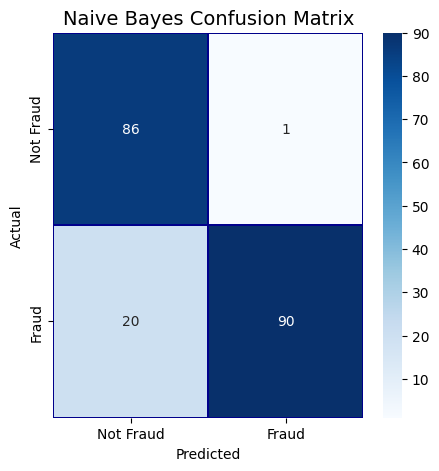

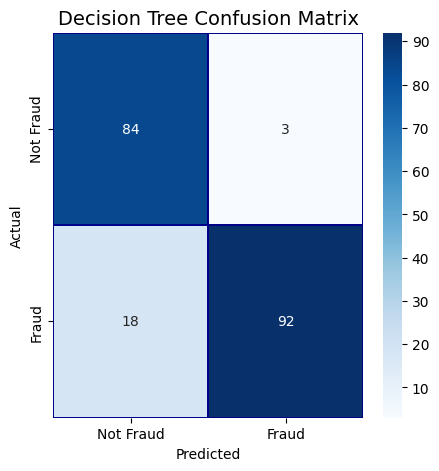

In [62]:
y_pred_nb = nb.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


naive_cf = confusion_matrix(y_test, y_pred_nb)
tree_cf = confusion_matrix(y_test, y_pred_tree)

cm = pd.crosstab(y_test, y_pred_nb, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Naive Bayes Confusion Matrix', fontsize=14)
plt.show()

cm = pd.crosstab(y_test, y_pred_tree, rownames=['Actual'], colnames=['Predicted'])
fig, (ax2) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax2,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Decision Tree Confusion Matrix', fontsize=14)
plt.show()

In [63]:
from sklearn.metrics import classification_report


print('Naive Bayes Classifier:')
print(classification_report(y_test, y_pred_nb))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        87
           1       0.99      0.82      0.90       110

    accuracy                           0.89       197
   macro avg       0.90      0.90      0.89       197
weighted avg       0.91      0.89      0.89       197

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        87
           1       0.97      0.84      0.90       110

    accuracy                           0.89       197
   macro avg       0.90      0.90      0.89       197
weighted avg       0.90      0.89      0.89       197



In [64]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred_nb)
print(f"AUC-ROC Curve for Naive Bayes with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for Naive Bayes with Class weights: 0.9033


In [65]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred_tree)
print(f"AUC-ROC Curve for Decision Trees with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for Decision Trees with Class weights: 0.9009


In [66]:
from sklearn.metrics import roc_curve
nb_fpr, nb_tpr, nb_thresold = roc_curve(y_test, y_pred_nb)

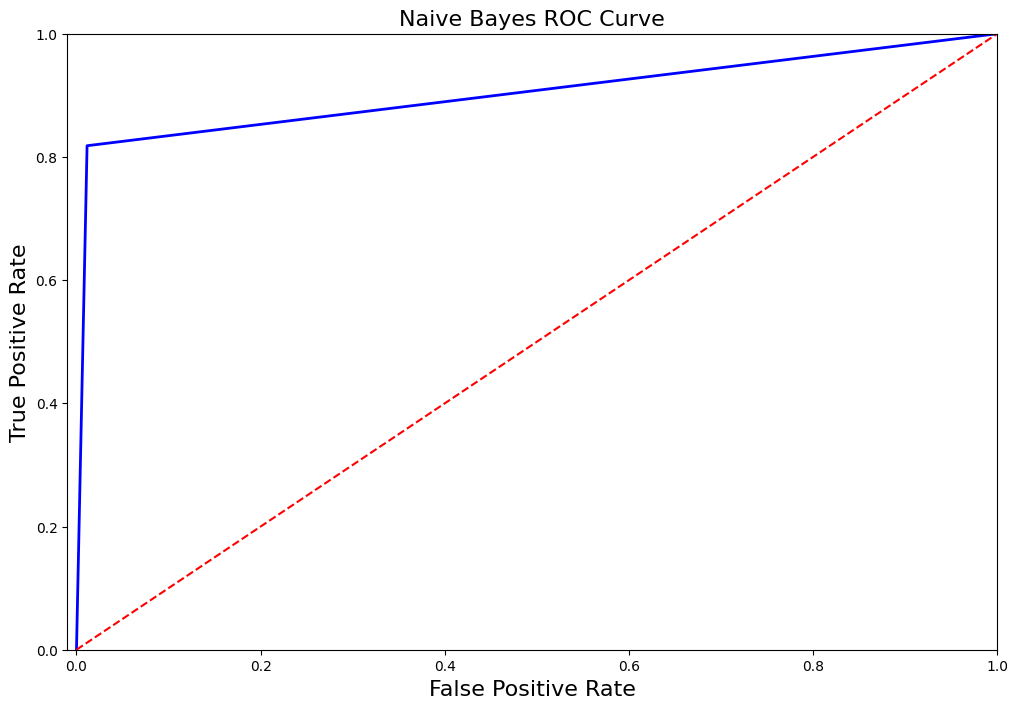

In [67]:
def plot_roc_curve(nb_fpr, nb_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Naive Bayes ROC Curve', fontsize=16)
    plt.plot(nb_fpr, nb_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
plot_roc_curve(nb_fpr, nb_tpr)
plt.show()

In [69]:
def plot_dt_roc_curve(dt_fpr, dt_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Decision Tree ROC Curve', fontsize=16)
    plt.plot(dt_fpr, dt_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    

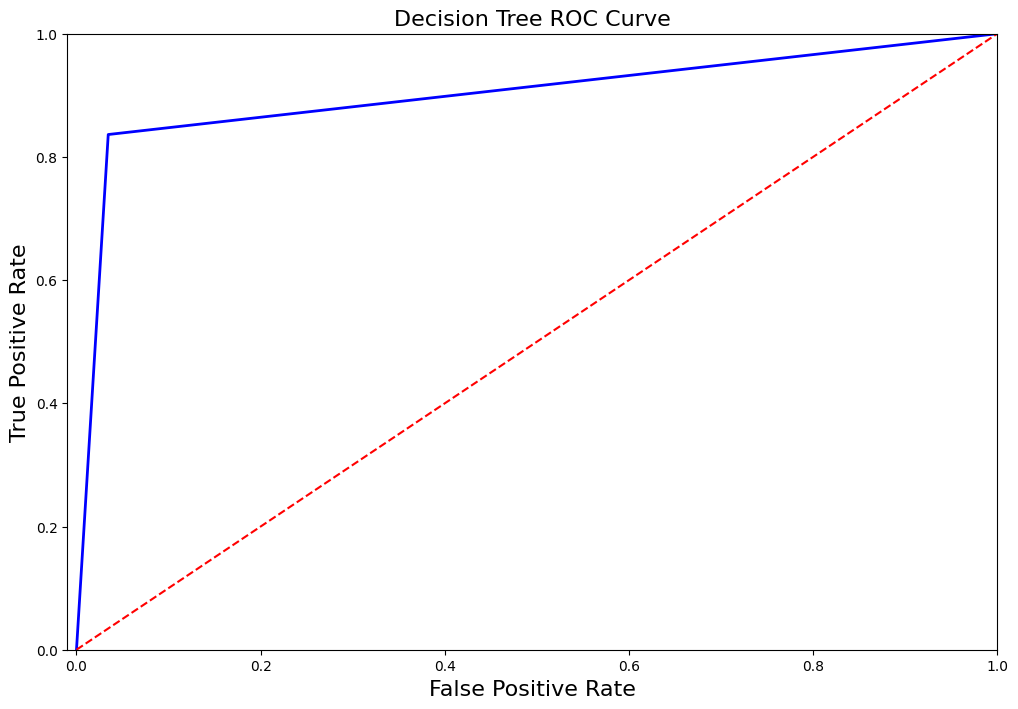

In [70]:
dt_fpr, dt_tpr, dt_thresold = roc_curve(y_test, y_pred_tree)
plot_dt_roc_curve(dt_fpr, dt_tpr)
plt.show()

In [183]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [184]:
#grid_rf.fit(X_train_rf,y_train_rf)
clf = RandomForestClassifier(n_jobs=4, 
                             random_state=2018,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)

In [185]:
clf.fit(X_train_rf,y_train_rf)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

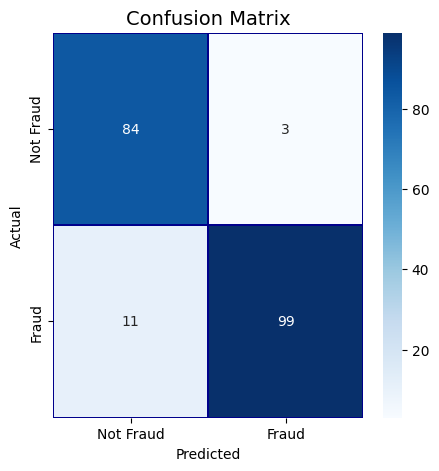

In [186]:
y_pred_rf = clf.predict(X_test_rf)



random_cf = confusion_matrix(y_test_rf, y_pred_rf)


cm = pd.crosstab(y_test_rf, y_pred_rf, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [187]:
y_test_rf.value_counts()

1    110
0     87
Name: Class, dtype: int64

In [188]:
print('Random Forest Classifier:')
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        87
           1       0.97      0.90      0.93       110

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



In [189]:
target = 'Class'
predictors = ['Time_Hr', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount_Scaled']

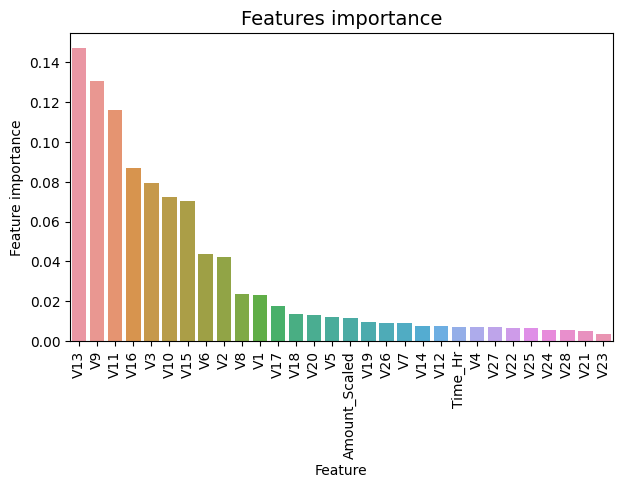

In [190]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [191]:
roc_auc_score(y_test_rf, y_pred_rf)

0.9327586206896551

In [192]:
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [71]:
y_under.value_counts()

0    492
1    492
Name: Class, dtype: int64

In [193]:
drop_list = ['V8','V1','V17','V18','V20','V5','Amount_Scaled','Time_Hr','V19','V26','V7','V14','V12','V4','V27','V22','V25','V24','V28','V21','V23']

In [194]:
X_train_fi.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
150654,-3.765680,5.890735,-10.202268,10.259036,-5.611448,-3.235376,-10.632683,3.272716,-5.268905,-11.182125,...,2.245606,0.546321,0.381853,0.382025,-0.821036,0.394355,1.412961,0.782407,26.065000,-0.359763
158741,-0.478347,1.152614,1.517142,1.176576,-0.864938,-0.275328,-0.239339,0.365595,-0.253614,-0.363320,...,-0.005763,0.046883,0.061172,0.412613,-0.672879,-0.199388,-0.021688,0.108916,31.027500,-0.349716
18809,0.923764,0.344048,-2.880004,1.721680,-3.019565,-0.639736,-3.801325,1.299096,0.864065,-2.895252,...,0.899931,1.481271,0.725266,0.176960,-1.815638,-0.536517,0.489035,-0.049729,8.273611,-0.237044
10630,-5.187878,6.967709,-13.510931,8.617895,-11.214422,0.672248,-9.462533,5.328704,-4.897006,-11.786812,...,2.086083,0.760190,0.716806,-0.646743,-1.617043,0.172347,0.626647,-0.169726,4.955000,2.745093
234705,-2.219219,0.727831,-5.458230,5.924850,3.932464,-3.085984,-1.677870,0.865075,-3.177260,-3.419207,...,0.417472,-0.817343,-0.028752,0.025723,-0.825835,-0.013089,0.413291,-0.131387,41.131667,-0.359804


In [195]:
X_train_fi=X_train_fi.drop(columns=drop_list,axis=1)
X_train_fi.head()

,V2,V3,V6,V9,V10,V11,V13,V15,V16
150654,5.890735,-10.202268,-3.235376,-5.268905,-11.182125,8.879476,-0.232822,0.141186,-12.186362
158741,1.152614,1.517142,-0.275328,-0.253614,-0.363320,-0.319530,0.922388,1.838977,-1.041269
18809,0.344048,-2.880004,-0.639736,0.864065,-2.895252,3.028162,-1.560432,1.078895,-4.702012
10630,6.967709,-13.510931,0.672248,-4.897006,-11.786812,9.369079,1.256377,0.274430,-10.688242
234705,0.727831,-5.458230,-3.085984,-3.177260,-3.419207,3.693174,-1.718591,-0.242965,1.174884


In [196]:
X_test_fi=X_test_fi.drop(columns=drop_list,axis=1)
X_test_fi.head()

,V2,V3,V6,V9,V10,V11,V13,V15,V16
8335,4.141986,-9.804103,-2.073129,-3.249516,-11.420451,10.853012,0.546690,0.912337,-12.227189
142405,1.264420,-5.167885,-2.096166,-3.214055,-8.745973,5.416042,-0.165011,-1.895210,-7.360475
106014,2.728085,0.201955,-0.972212,1.037606,1.315156,0.130270,1.237413,0.663840,0.233683
241254,1.659093,-3.071421,-1.892388,-1.670173,-3.508925,1.439322,0.767485,1.058566,-0.997477
33276,-5.198360,-3.000024,-3.394483,0.658176,-0.794994,3.266066,-0.124104,0.638575,-2.995830


In [197]:
nb.fit(X_train_fi, y_train_fi)

GaussianNB()

In [199]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train_fi, y_train_fi)
tree_clf = grid_tree.best_estimator_

In [162]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(nb, X_train_fi, y_train_fi, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.85714286 0.80519481 0.80263158 0.84210526 0.80263158]
Average Cross Validation Recall score: 0.8219412166780588


In [200]:
tree_score = cross_val_score(tree_clf, X_train_fi, y_train_fi, cv=5)
print("Cross Validation Recall scores are: {}".format(tree_score))
print("Average Cross Validation Recall score: {}".format(tree_score.mean()))

Cross Validation Recall scores are: [0.91139241 0.92405063 0.91082803 0.91082803 0.91082803]
Average Cross Validation Recall score: 0.913585422881561


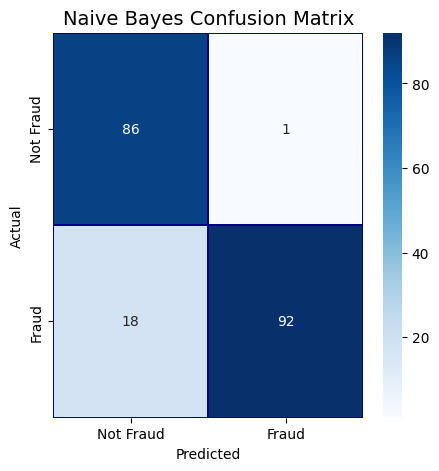

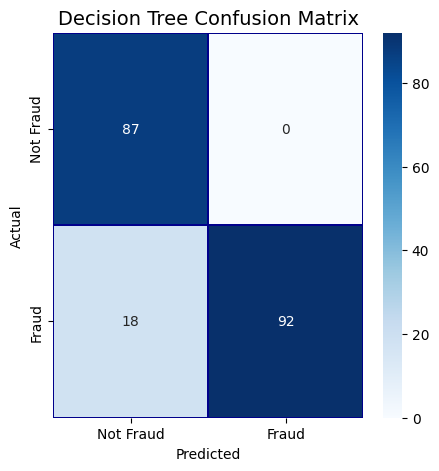

In [201]:
y_pred_nb = nb.predict(X_test_fi)
y_pred_tree = tree_clf.predict(X_test_fi)


naive_cf = pd.crosstab(y_test_fi, y_pred_nb, rownames=['Actual'], colnames=['Predicted'])
tree_cf = pd.crosstab(y_test_fi, y_pred_tree, rownames=['Actual'], colnames=['Predicted'])


cm = pd.crosstab(y_test_fi, y_pred_nb, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Naive Bayes Confusion Matrix', fontsize=14)
plt.show()

cm = pd.crosstab(y_test_fi, y_pred_tree, rownames=['Actual'], colnames=['Predicted'])
fig, (ax2) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax2,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Decision Tree Confusion Matrix', fontsize=14)
plt.show()



In [202]:
print('Naive Bayes Classifier:')
print(classification_report(y_test_fi, y_pred_nb))
print('Decision Tree Classifier:')
print(classification_report(y_test_fi, y_pred_tree))

Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90        87
           1       0.99      0.84      0.91       110

    accuracy                           0.90       197
   macro avg       0.91      0.91      0.90       197
weighted avg       0.92      0.90      0.90       197

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        87
           1       1.00      0.84      0.91       110

    accuracy                           0.91       197
   macro avg       0.91      0.92      0.91       197
weighted avg       0.92      0.91      0.91       197



In [123]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
count,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,...,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000
mean,-2.293928,1.691881,-3.348689,2.226133,-1.482693,-0.696814,-2.732870,0.342355,-1.253221,-2.730168,...,0.310880,-0.010629,-0.013281,-0.040343,0.022094,0.034542,0.108626,0.004846,24.742937,0.028921
std,5.480135,3.694812,6.160484,3.234660,4.201441,1.748817,5.808856,4.802977,2.307595,4.483748,...,2.694793,1.156288,1.267982,0.574178,0.666116,0.495549,0.931885,0.438348,13.101484,0.768139
min,-30.552380,-14.440363,-31.103685,-4.005898,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.174059,-5.682338,-2.404684,0.112778,-0.359804
25%,-2.765686,-0.213767,-4.695493,-0.143940,-1.703222,-1.539592,-2.987206,-0.196149,-2.199053,-4.376972,...,-0.199354,-0.557494,-0.239310,-0.388725,-0.303963,-0.288849,-0.071767,-0.068825,13.778194,-0.352552
50%,-0.712886,0.938944,-1.180607,1.280707,-0.401125,-0.625962,-0.592484,0.131637,-0.694696,-0.745317,...,0.129372,-0.025092,-0.036560,0.018336,0.053482,-0.007772,0.043095,0.025454,23.434167,-0.278774
75%,1.081062,2.571398,0.428826,4.177147,0.488638,0.081171,0.250640,0.857639,0.213369,0.046772,...,0.596733,0.547289,0.198961,0.408294,0.384724,0.328047,0.418542,0.174908,36.575000,0.045304
max,2.329675,22.057729,3.435602,12.114672,11.095089,6.474115,5.868109,20.007208,4.145546,4.927785,...,27.202839,8.361985,8.719703,1.153636,2.498300,3.155327,5.018986,1.779364,47.733056,6.972089


In [124]:
X_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,...,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,-2.730040,2.112996,-3.963771,2.445699,-1.800002,-0.756354,-2.980579,0.274906,-1.501323,-3.238718,...,0.437992,-0.113731,0.021166,-0.111609,0.026530,0.033645,-0.010799,0.071755,23.064588,0.108124
std,5.739005,3.759370,6.581850,3.106674,4.328513,1.710158,6.014956,5.033104,2.332992,4.694901,...,3.127922,1.240629,0.764978,0.554489,0.687041,0.517468,1.290930,0.424568,13.290663,1.116934
min,-28.524268,-7.159042,-30.177317,-3.190086,-20.786000,-5.140999,-31.197329,-37.353443,-9.462573,-22.187089,...,-8.755698,-8.887017,-1.800985,-1.728406,-2.187593,-1.123534,-7.263482,-1.324884,0.297778,-0.359804
25%,-3.502244,-0.034899,-6.092255,0.053740,-2.233983,-1.755633,-3.358857,-0.192892,-2.748496,-5.134454,...,-0.235020,-0.605759,-0.245076,-0.437619,-0.324494,-0.308943,-0.053290,-0.053133,11.474444,-0.355752
50%,-0.967767,1.056456,-1.880372,1.993117,-0.416623,-0.788801,-0.902376,0.163408,-0.923038,-1.481246,...,0.193700,-0.166029,-0.023512,-0.038608,0.057425,-0.006810,0.114328,0.065039,21.088333,-0.283231
75%,0.437174,3.375110,0.314103,4.455923,0.616297,0.102709,0.310099,0.993702,0.125466,-0.173383,...,0.764187,0.464777,0.193731,0.254836,0.359257,0.323784,0.454851,0.246394,35.895000,0.045304
max,2.220941,16.497472,2.788555,11.165526,3.932464,5.760059,2.880083,18.748872,2.820829,6.335300,...,27.202839,3.460893,5.303607,0.982567,2.051687,2.154778,2.262942,1.773326,46.851389,8.253129


In [125]:
y_train.value_counts()

0    405
1    382
Name: Class, dtype: int64

In [126]:
y_test.value_counts()

1    110
0     87
Name: Class, dtype: int64

In [127]:
from sklearn import svm
classifier_svm = svm.SVC(kernel='linear') 

In [128]:
classifier_svm.fit(X_train,y_train)

SVC(kernel='linear')

In [129]:
prediction_svm_all = classifier_svm.predict(X_test_all)

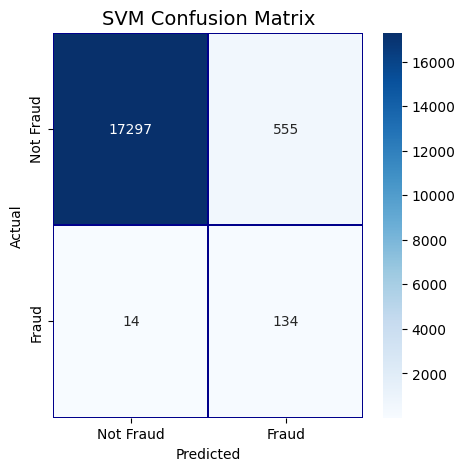

In [130]:
cm = pd.crosstab(y_test_all, prediction_svm_all, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues",fmt='.0f')
plt.title('SVM Confusion Matrix', fontsize=14)
plt.show()

In [131]:
print('SVM Classifier:')
print(classification_report(y_test_all, prediction_svm_all))

SVM Classifier:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     17852
           1       0.19      0.91      0.32       148

    accuracy                           0.97     18000
   macro avg       0.60      0.94      0.65     18000
weighted avg       0.99      0.97      0.98     18000



In [133]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[0][1]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[0][1])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 134 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.9054054054054054
the accuracy is : 0.9683888888888889


In [109]:
#Testing on important features
drop_list = ['V8','V1','V17','V18','V20','V5','Amount_Scaled','Time_Hr','V19','V26','V7','V14','V12','V4','V27','V22','V25','V24','V28','V21','V23']

In [110]:
X_train_fi=X_train.drop(columns=drop_list,axis=1)
X_train_fi.head()

,V2,V3,V6,V9,V10,V11,V13,V15,V16
154694,4.569649,-9.553069,-1.877981,-2.503304,-7.575634,7.002136,2.122072,-1.644857,-7.189926
179912,0.255907,-1.013279,0.584955,-0.651258,1.326775,-2.291508,0.597518,-1.456172,0.676998
184379,1.927650,-3.905356,-1.756999,-2.770148,-3.216188,1.286749,1.042216,-0.668137,-3.865976
44001,1.073499,-2.773663,0.747235,-2.431862,-4.155838,4.354775,0.468875,0.699671,-2.901141
235616,2.715855,-5.111658,-0.882446,-3.627698,-1.873331,1.203834,-0.921364,-0.062221,-5.241049


In [111]:
X_test_fi=X_test.drop(columns=drop_list,axis=1)
X_test_fi.head()

,V2,V3,V6,V9,V10,V11,V13,V15,V16
69980,1.344521,-0.534379,-1.261961,-1.416265,-2.996669,0.747478,-1.927760,-1.247815,-2.535494
48094,0.716242,-1.143279,-1.168952,-1.611155,-1.250286,3.367361,-0.806940,0.525824,-1.815914
28556,0.260539,-0.149004,-0.034083,0.142757,-0.316197,-0.796026,0.085980,1.451903,0.493513
191690,3.057250,-6.161997,-1.848006,-2.959806,-3.851722,4.513355,-1.765734,-0.439394,0.574875
141258,3.462889,-6.445104,-2.291561,-4.322377,-8.099119,7.182967,-0.314620,-0.136359,-6.367524


In [112]:
classifier_svm_weights = svm.SVC(kernel='linear',class_weight={0:0.60, 1:0.40})

In [113]:
classifier_svm_weights.fit(X_train, y_train) 

SVC(class_weight={0: 0.6, 1: 0.4}, kernel='linear')

In [114]:
prediction_svm_weight_all = classifier_svm_weights.predict(X_test_all)

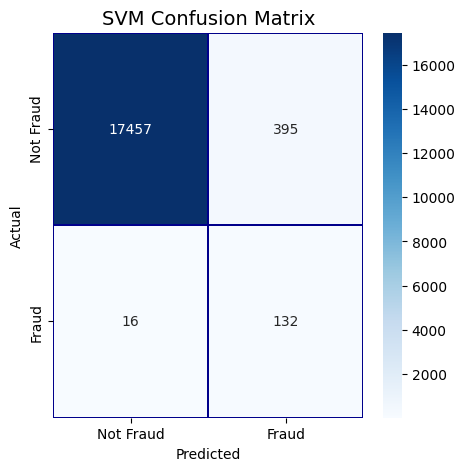

In [115]:
cm = pd.crosstab(y_test_all, prediction_svm_weight_all, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues",fmt='.0f')
plt.title('SVM Confusion Matrix', fontsize=14)
plt.show()

In [116]:
y_train_fi=y_train
y_test_fi=y_test

In [117]:
classifier_svm_fi = svm.SVC(kernel='linear')

In [118]:
classifier_svm_fi.fit(X_train_fi,y_train_fi)

SVC(kernel='linear')

In [120]:
prediction_svm_fi_all = classifier_svm_fi.predict(X_test_fi)

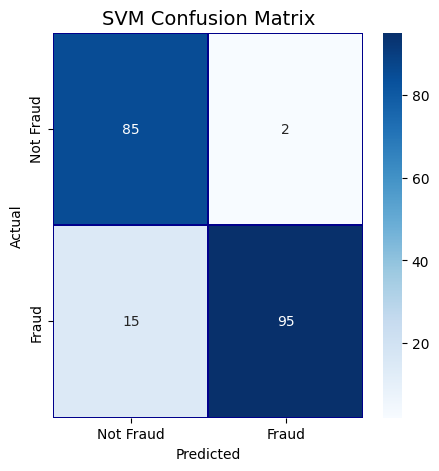

In [121]:
cm = pd.crosstab(y_test_fi, prediction_svm_fi_all, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('SVM Confusion Matrix', fontsize=14)
plt.show()



Confusion Matrix for C=0.1 and kernel=linear


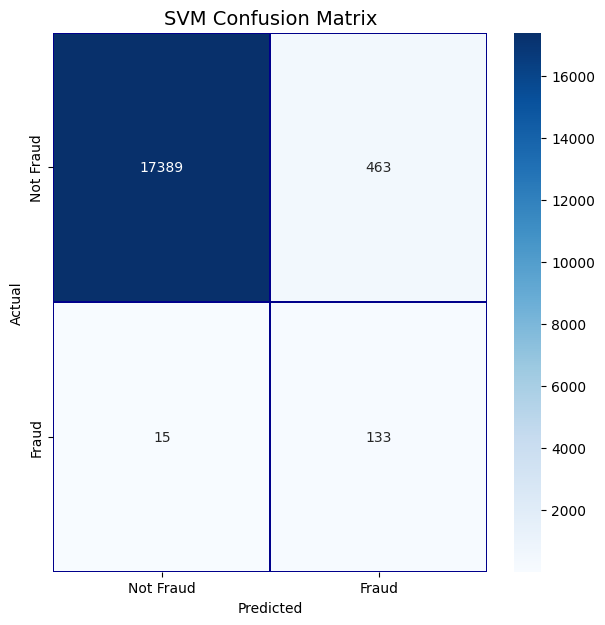

We have detected 133 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.8986486486486487
the accuracy is : 0.9734444444444444


Confusion Matrix for C=0.1 and kernel=poly


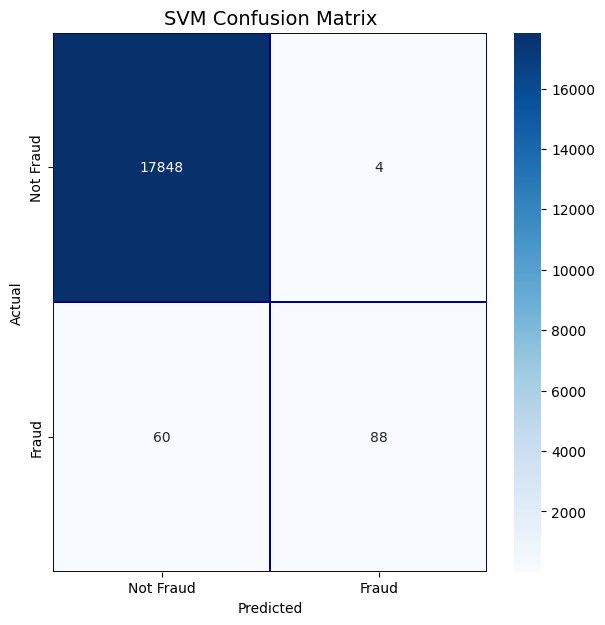

We have detected 88 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.5945945945945946
the accuracy is : 0.9964444444444445


Confusion Matrix for C=0.1 and kernel=rbf


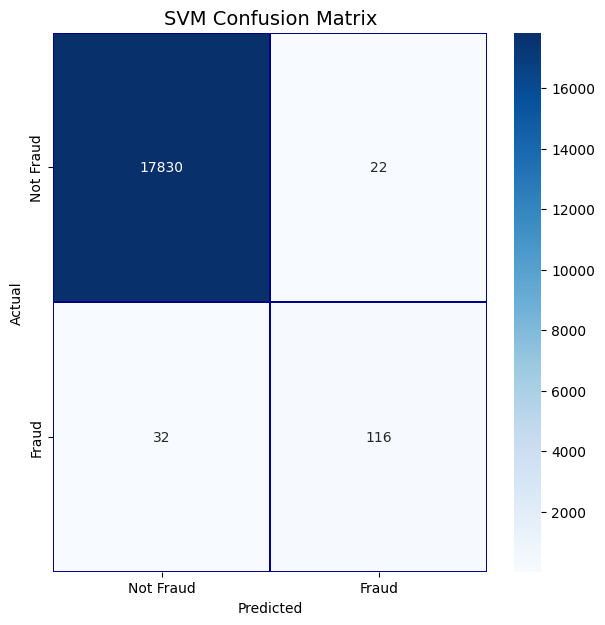

We have detected 116 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.7837837837837838
the accuracy is : 0.997


Confusion Matrix for C=1 and kernel=linear


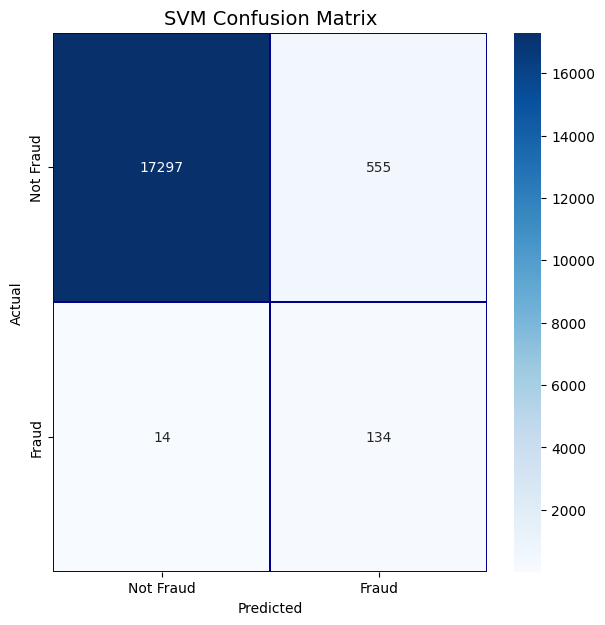

We have detected 134 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.9054054054054054
the accuracy is : 0.9683888888888889


Confusion Matrix for C=1 and kernel=poly


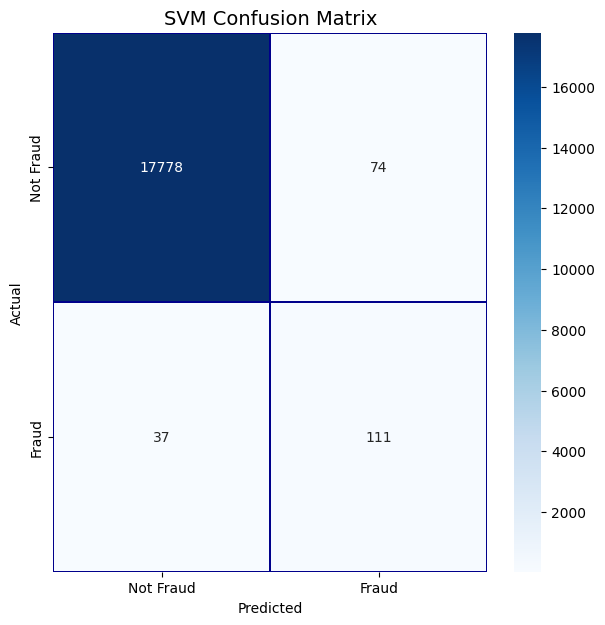

We have detected 111 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.75
the accuracy is : 0.9938333333333333


Confusion Matrix for C=1 and kernel=rbf


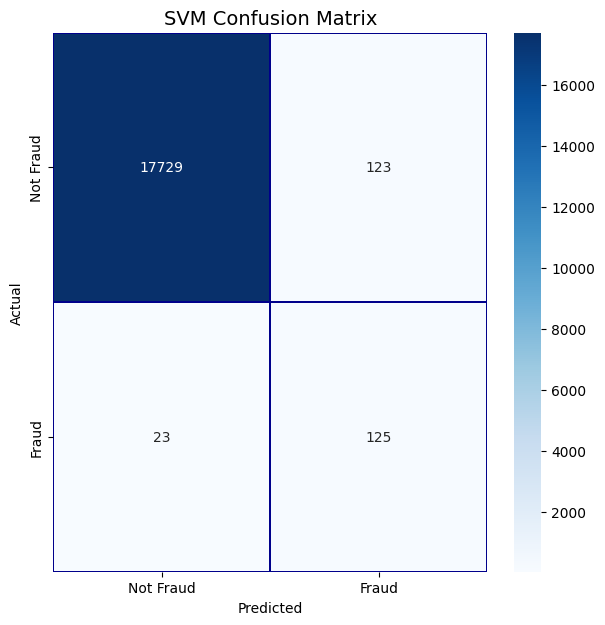

We have detected 125 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.8445945945945946
the accuracy is : 0.9918888888888889


Confusion Matrix for C=10 and kernel=linear


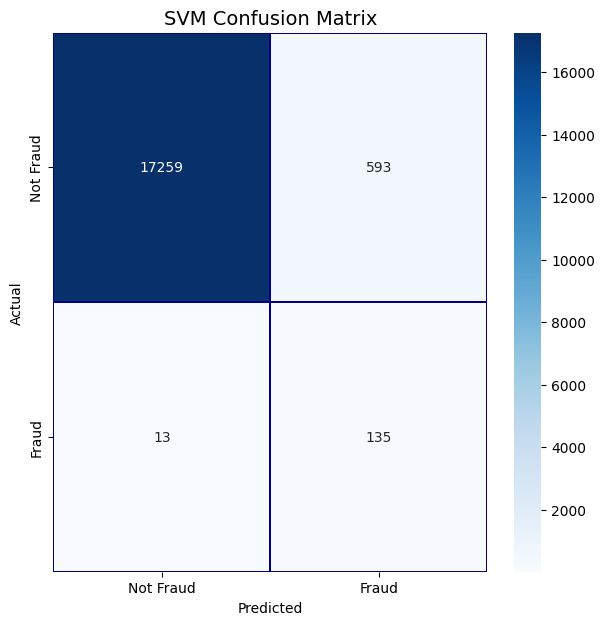

We have detected 135 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.9121621621621622
the accuracy is : 0.9663333333333334


Confusion Matrix for C=10 and kernel=poly


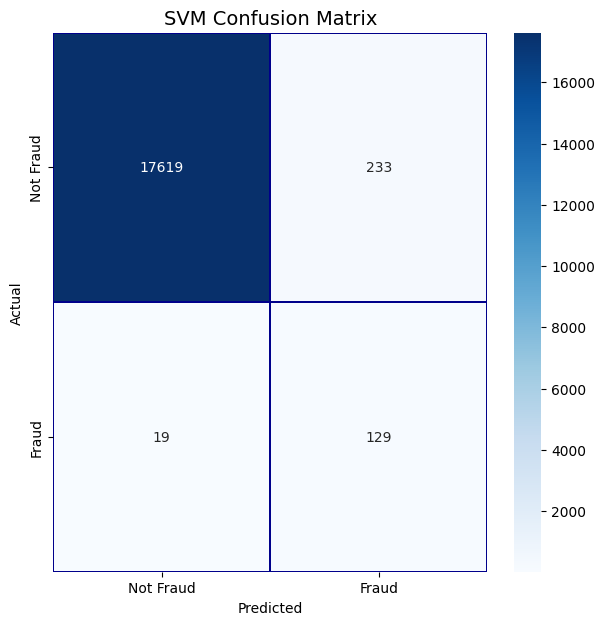

We have detected 129 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.8716216216216216
the accuracy is : 0.986


Confusion Matrix for C=10 and kernel=rbf


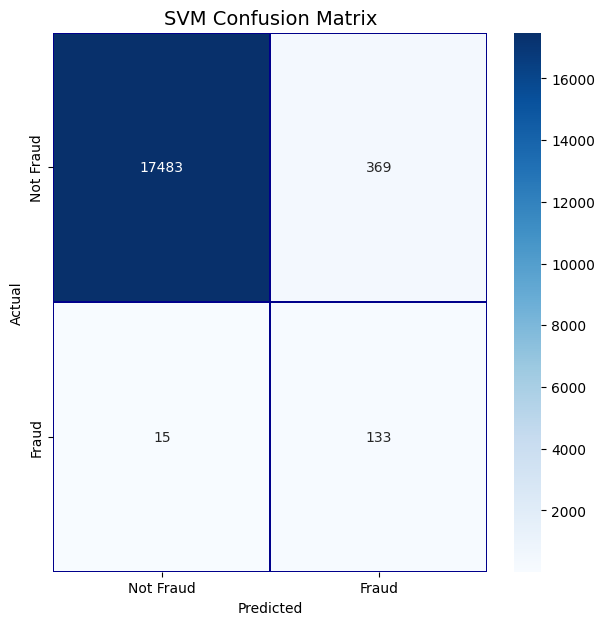

We have detected 133 frauds / 148 total frauds.

So, the probability to detect a fraud is 0.8986486486486487
the accuracy is : 0.9786666666666667


In [136]:
C_list = [0.1, 1, 10]
kernel_list = ['linear', 'poly', 'rbf']

# Loop over the C values and kernel functions
for C in C_list:
    for kernel in kernel_list:
        # Create an SVM classifier with the given C and kernel
        clf = SVC(C=C, kernel=kernel, gamma='scale')
        # Fit the classifier on the training data
        clf.fit(X_train, y_train)
        # Compute the accuracy on the test data
        #accuracy = clf.score(X_test_all, y_test_all)
        prediction_svm_all_k = clf.predict(X_test_all)
        print('\n') 
        print("Confusion Matrix for C=%s and kernel=%s" % (C, kernel))
        cm = pd.crosstab(y_test_all, prediction_svm_all_k, rownames=['Actual'], colnames=['Predicted'])
        fig, (ax1) = plt.subplots(ncols=1, figsize=(7,7))
        sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues",fmt='.0f')
        plt.title('SVM Confusion Matrix', fontsize=14)
        plt.show()
        print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[0][1]) + ' total frauds.')
        print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[0][1])))
        print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))    

In [137]:
# From the above svm for different kernels and different c value we can say that for va;lue c=10 and kernel=linear 
# we have the best fraud accuracy which is 91.2% and overall accuracy of 96.6%

# Though the best overall accuracy was achieved by the kernel=rbf with c value=0.1 but our goal is to attain maximum accuracy for fraudulent
# transactions where it performed poorly with 78% accuracy